In [863]:
import os
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the Final Flight Data
First we connect to our database.

In [417]:
%load_ext sql
%sql postgresql://localhost/amidatabase

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


'Connected: @amidatabase'

In order to write PostgreSQL queries, we must create an engine.

In [261]:
engine = create_engine('postgresql+psycopg2://Blake Bullwinkel:postgres@localhost/amidatabase')

We now read the final .txt files into our database while also parsing the file names to add EventStartTime and Participant_id columns to each table.

In [162]:
basepath = r'C:\Users\Blake Bullwinkel\Downloads\WSSCGQWVS Corrected Sim Segments\Final Paths Blake'
with os.scandir(basepath) as entries:
    for entry in entries:
        # we read all files in the directory that end in .txt
        if entry.name[-4:]=='.txt':
            path = pd.read_csv(entry,sep='	')
            path['EventStartTime'] = entry.name[-23:-10]
            path['Participant_id'] = entry.name[-9:-4]
            path.to_sql(entry.name[:-4],engine)

The \dt SQL command displays all the tables in our database.

In [290]:
%sql \dt

 * postgresql://localhost/amidatabase
15 rows affected.


Schema,Name,Type,Owner
public,Final_AFRLAgent_5611620001340_P8666,table,Blake Bullwinkel
public,Final_AFRLAgent_6010571848831_P8099,table,Blake Bullwinkel
public,Final_AFRLAgent_6054129383014_P3233,table,Blake Bullwinkel
public,Final_AFRLAgent_6116054505008_P6109,table,Blake Bullwinkel
public,Final_AFRLAgent_6152807954238_P3061,table,Blake Bullwinkel
public,Final_AFRLAgent_6168263773276_P5454,table,Blake Bullwinkel
public,Final_AFRLAgent_6201001215825_P3130,table,Blake Bullwinkel
public,Final_AFRLAgent_6206460016536_P7234,table,Blake Bullwinkel
public,Final_AFRLAgent_6239379978497_P7438,table,Blake Bullwinkel
public,Final_AFRLAgent_6306616351170_P7442,table,Blake Bullwinkel


# Analyzing Blue
First, we investigate the blue flight paths. Note that threats occur at the beginning of segments D (WP7-10), E (WP11-14), G (WP19-22) and I (WP27-30). We can verify this by observing the waypoint codes where TrafficEventType_code is equal to 0.

In [511]:
%%sql
SELECT "TrafficEventType_code", "RelatedWayPoint_code", "PreviousWayPoint_code", "NextWayPoint_code"
FROM "Final_AFRLAgent_5611620001340_P8666"
WHERE "TrafficEventType_code" IS NOT NULL

 * postgresql://localhost/amidatabase
8 rows affected.


TrafficEventType_code,RelatedWayPoint_code,PreviousWayPoint_code,NextWayPoint_code
0.0,7.0,6.0,7.0
1.0,7.0,7.0,8.0
0.0,11.0,10.0,11.0
3.0,11.0,11.0,12.0
0.0,19.0,18.0,19.0
1.0,19.0,19.0,20.0
0.0,27.0,26.0,27.0
1.0,27.0,27.0,28.0


## Q1. Is there a learning/fatigue effect in the n-back task across the blue flight data?
To answer this question, we first look at average n-back reaction times across all the blue flight paths. In this scatter plot, we exclude reaction time values equal to -1 (participant did not make a response).

[(0, 1200)]

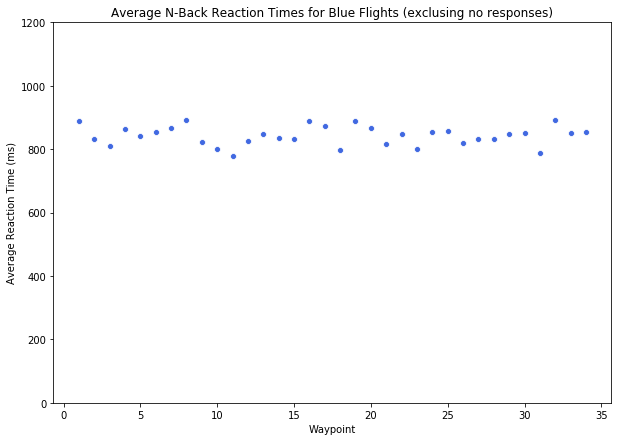

In [657]:
with engine.connect() as connection:
    reaction_times = pd.read_sql("""
        SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_5611620001340_P8666"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6010571848831_P8099"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6054129383014_P3233"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6116054505008_P6109"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6306616351170_P7442"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6454302531282_P8543"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6709586887529_P5510"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_7167357727955_P5427"
        ORDER BY "NextWayPoint_code"
        """,connection)

reaction_times = reaction_times[reaction_times["ReactionTime_msec"] != -1]
grouped_reaction_times = reaction_times.groupby(["NextWayPoint_code"]).mean().reset_index()

fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x="NextWayPoint_code",y="ReactionTime_msec",data=grouped_reaction_times,color="royalblue")
ax.set_title('Average N-Back Reaction Times for Blue Flights (exclusing no responses)')
ax.set_xlabel('Waypoint')
ax.set_ylabel('Average Reaction Time (ms)')
ax.set(ylim=(0, 1200))

This graph suggestions little variation in average reaction time over the course of the flights. In the next plot, we account for instances when participants did not make a response by setting all reaction time values at -1 to 3250ms (the maximum possible reaction time that could have been recorded).

[(0, 1600)]

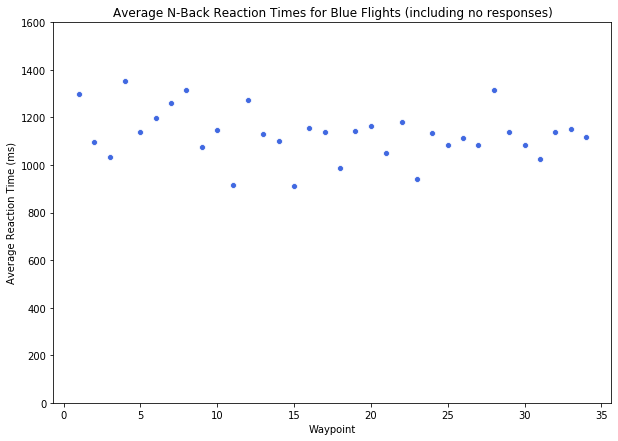

In [656]:
with engine.connect() as connection:
    reaction_times = pd.read_sql("""
        SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_5611620001340_P8666"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6010571848831_P8099"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6054129383014_P3233"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6116054505008_P6109"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6306616351170_P7442"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6454302531282_P8543"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6709586887529_P5510"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_7167357727955_P5427"
        ORDER BY "NextWayPoint_code"
        """,connection)

reaction_times.loc[reaction_times["ReactionTime_msec"]==-1, ["ReactionTime_msec"]] = 3250
grouped_reaction_times = reaction_times.groupby(["NextWayPoint_code"]).mean().reset_index()

fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x="NextWayPoint_code",y="ReactionTime_msec",data=grouped_reaction_times,color="royalblue")
ax.set_title('Average N-Back Reaction Times for Blue Flights (including no responses)')
ax.set_xlabel('Waypoint')
ax.set_ylabel('Average Reaction Time (ms)')
ax.set(ylim=(0, 1600))

While the variance of our data has increased, this graph still shows a roughly constant average reaction time, suggesting that there is little to no learning or fatigue effect over the course of the blue flights. To investigate this hypothesis further, let's calculate the number of times participants responded to the n-back test late by waypoint.

Text(0, 0.5, 'Number of Late Responses')

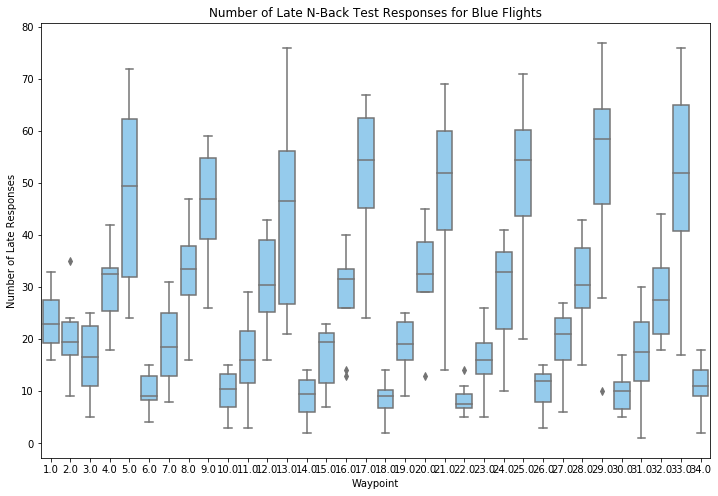

In [655]:
with engine.connect() as connection:
    late_responses = pd.read_sql("""
        SELECT "NextWayPoint_code", COUNT("IsTimeUp") FROM "Final_AFRLAgent_5611620001340_P8666" WHERE "IsTimeUp"=1 GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("IsTimeUp") FROM "Final_AFRLAgent_6010571848831_P8099" WHERE "IsTimeUp"=1 GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("IsTimeUp") FROM "Final_AFRLAgent_6054129383014_P3233" WHERE "IsTimeUp"=1 GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("IsTimeUp") FROM "Final_AFRLAgent_6116054505008_P6109" WHERE "IsTimeUp"=1 GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("IsTimeUp") FROM "Final_AFRLAgent_6306616351170_P7442" WHERE "IsTimeUp"=1 GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("IsTimeUp") FROM "Final_AFRLAgent_6454302531282_P8543" WHERE "IsTimeUp"=1 GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("IsTimeUp") FROM "Final_AFRLAgent_6709586887529_P5510" WHERE "IsTimeUp"=1 GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("IsTimeUp") FROM "Final_AFRLAgent_7167357727955_P5427" WHERE "IsTimeUp"=1 GROUP BY "NextWayPoint_code"
        ORDER BY "NextWayPoint_code"
        """,connection)

fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x="NextWayPoint_code",y="count",data=late_responses,color="lightskyblue")
ax.set_title('Number of Late N-Back Test Responses for Blue Flights')
ax.set_xlabel('Waypoint')
ax.set_ylabel('Number of Late Responses')

Here we see that the average number of late n-back test responses varies regularly over the course of the blue flights (we see 8 similar cyles corresponding to the 8 segments). Finally, let's also check how the number of times participants did not respond at all varies.

Text(0, 0.5, 'Number of Times Participants Did Not Respond')

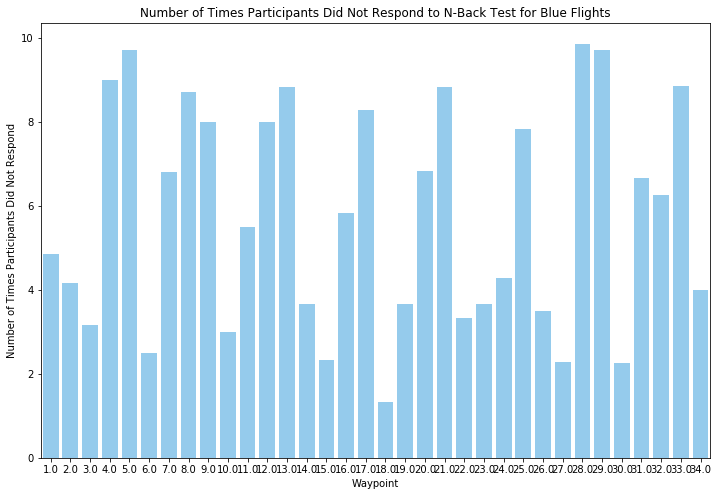

In [654]:
with engine.connect() as connection:
    no_responses = pd.read_sql("""
        SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") FROM "Final_AFRLAgent_5611620001340_P8666" WHERE "ReactionTime_msec"=1 GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") FROM "Final_AFRLAgent_6010571848831_P8099" WHERE "ReactionTime_msec"=-1 GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") FROM "Final_AFRLAgent_6054129383014_P3233" WHERE "ReactionTime_msec"=-1 GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") FROM "Final_AFRLAgent_6116054505008_P6109" WHERE "ReactionTime_msec"=-1 GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") FROM "Final_AFRLAgent_6306616351170_P7442" WHERE "ReactionTime_msec"=-1 GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") FROM "Final_AFRLAgent_6454302531282_P8543" WHERE "ReactionTime_msec"=-1 GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") FROM "Final_AFRLAgent_6709586887529_P5510" WHERE "ReactionTime_msec"=-1 GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") FROM "Final_AFRLAgent_7167357727955_P5427" WHERE "ReactionTime_msec"=-1 GROUP BY "NextWayPoint_code"
        ORDER BY "NextWayPoint_code"
        """,connection)

grouped_no_responses = no_responses.groupby(["NextWayPoint_code"]).mean().reset_index()    

fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x="NextWayPoint_code",y="count",data=grouped_no_responses,color="lightskyblue")
ax.set_title('Number of Times Participants Did Not Respond to N-Back Test for Blue Flights')
ax.set_xlabel('Waypoint')
ax.set_ylabel('Number of Times Participants Did Not Respond')

We do not see any strong trend in the number of times participants did not respond over the course of the entire flight, and thus can conclude that **there is no learning/fatigue effect in the n-back task across the blue flights**. However, we do see that certain portions of the flight path have higher non-response counts than others. In the next section, we split the flight paths into intervals that contain threats and those that do not.

## Q2. What is the effect of threat events on n-back task reaction time in the blue flight data?
We first create a plot that is similar to our previous bar graph but accounts for different path lengths by calculating the *proportion* of times that participants did not respond to the n-back task. Waypoints where pilots encounter threats are colored in dark blue.

Text(0, 0.5, 'Proportion of Times Participants Did Not Respond')

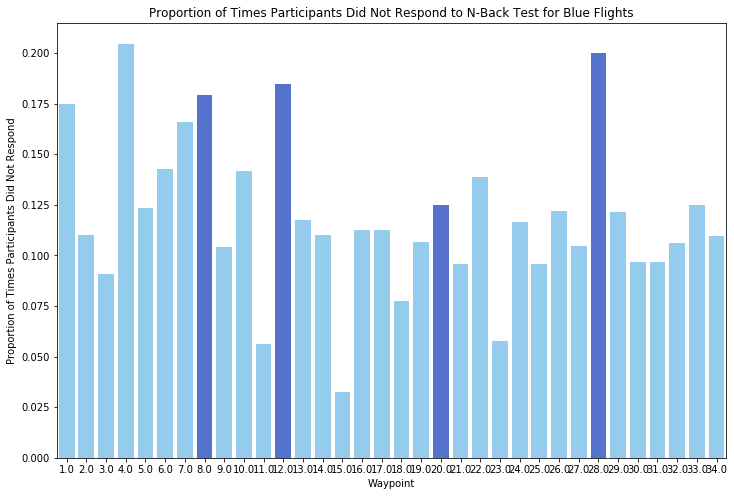

In [653]:
with engine.connect() as connection:
    no_responses = pd.read_sql("""
        SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") AS total, SUM(CASE WHEN "ReactionTime_msec"=-1 THEN 1 ELSE 0 END) AS missed FROM "Final_AFRLAgent_5611620001340_P8666" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") AS total, SUM(CASE WHEN "ReactionTime_msec"=-1 THEN 1 ELSE 0 END) AS missed FROM "Final_AFRLAgent_6010571848831_P8099" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") AS total, SUM(CASE WHEN "ReactionTime_msec"=-1 THEN 1 ELSE 0 END) AS missed FROM "Final_AFRLAgent_6054129383014_P3233" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") AS total, SUM(CASE WHEN "ReactionTime_msec"=-1 THEN 1 ELSE 0 END) AS missed FROM "Final_AFRLAgent_6116054505008_P6109" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") AS total, SUM(CASE WHEN "ReactionTime_msec"=-1 THEN 1 ELSE 0 END) AS missed FROM "Final_AFRLAgent_6306616351170_P7442" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") AS total, SUM(CASE WHEN "ReactionTime_msec"=-1 THEN 1 ELSE 0 END) AS missed FROM "Final_AFRLAgent_6454302531282_P8543" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") AS total, SUM(CASE WHEN "ReactionTime_msec"=-1 THEN 1 ELSE 0 END) AS missed FROM "Final_AFRLAgent_6709586887529_P5510" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") AS total, SUM(CASE WHEN "ReactionTime_msec"=-1 THEN 1 ELSE 0 END) AS missed FROM "Final_AFRLAgent_7167357727955_P5427" GROUP BY "NextWayPoint_code"
        ORDER BY "NextWayPoint_code"
        """,connection)

grouped_no_responses = no_responses.groupby(["NextWayPoint_code"]).mean().reset_index()
grouped_no_responses["proportion"] = grouped_no_responses["missed"]/grouped_no_responses["total"]

fig, ax = plt.subplots(figsize=(12,8))
clrs = ['royalblue' if (x in [8,12,20,28]) else "lightskyblue" for x in grouped_no_responses["NextWayPoint_code"]]
sns.barplot(x="NextWayPoint_code",y="proportion",data=grouped_no_responses,palette=clrs)
ax.set_title('Proportion of Times Participants Did Not Respond to N-Back Test for Blue Flights')
ax.set_xlabel('Waypoint')
ax.set_ylabel('Proportion of Times Participants Did Not Respond')

Observe that waypoints containing threats generally also have higher proportions of times when participants did not respond to the n-back task. This suggests that pilots were more distracted during threat events and were more likely to forget about the n-back task. We can also see that participants tended not to respond to the task while approaching waypoints 1 and 4, which correspond to the first section and the first turn of the flight path, respectively. It is reasonable to assume that during these periods, pilots were still getting used to the simulation and were therefore more likely to neglect the n-back task even though no threats were present.

With this in mind, let's plot the average n-back reaction times at waypoints immediately before, during, and immediately after threat events. Again, waypoints with threat events are colored in dark blue.

Text(0, 0.5, 'N-Back Reaction Time (ms)')

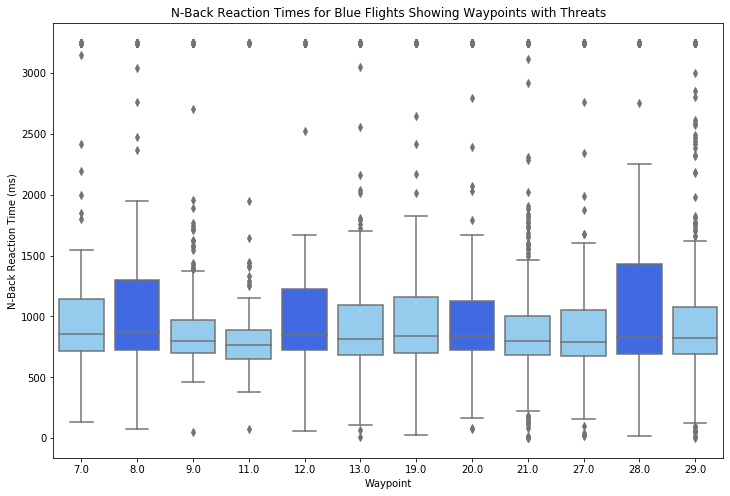

In [652]:
with engine.connect() as connection:
    reaction_times = pd.read_sql("""
        SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_5611620001340_P8666"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6010571848831_P8099"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6054129383014_P3233"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6116054505008_P6109"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6306616351170_P7442"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6454302531282_P8543"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6709586887529_P5510"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_7167357727955_P5427"
        ORDER BY "NextWayPoint_code"
        """,connection)

reaction_times = reaction_times[reaction_times["NextWayPoint_code"].isin([7,8,9,11,12,13,19,20,21,27,28,29])]
reaction_times.loc[reaction_times["ReactionTime_msec"]==-1, ["ReactionTime_msec"]] = 3250

fig, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(x="NextWayPoint_code", y="ReactionTime_msec", data=reaction_times,color="lightskyblue")
boxes = [ax.artists[i] for i in [1,4,7,10]]
for box in boxes:
    box.set_facecolor("royalblue")
ax.set_title('N-Back Reaction Times for Blue Flights Showing Waypoints with Threats')
ax.set_xlabel('Waypoint')
ax.set_ylabel('N-Back Reaction Time (ms)')

As expected, waypoints with threat events generally correspond to slower n-back reaction times in comparison to the segments immediately before and after. This strengthens our hypothesis that **threat events generally result in slower n-back reaction times** in the blue flight data. However, in order to fully assess the effect of threat events on n-back task performance, we must consider not only the reaction time but also the *accuracy* of responses. 

## Q3. What is the effect of threat events on n-back task accuracy in the blue flight data?
Let's start by creating a similar boxplot that displays the percentage of correct n-back responses immediately before, during, and immediately after threat events.

Text(0, 0.5, 'Percent Correct (%)')

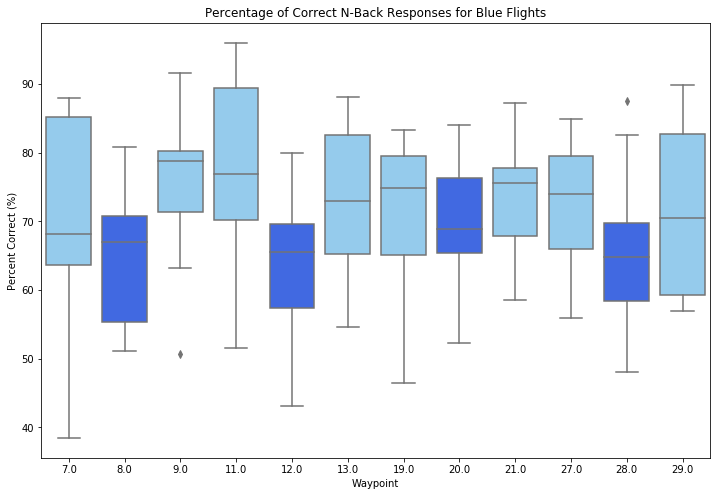

In [651]:
with engine.connect() as connection:
    answer_codes = pd.read_sql("""
        SELECT "NextWayPoint_code", COUNT("ExpectedAnswer_code") AS total, SUM(CASE WHEN "ExpectedAnswer_code"="AnswerGiven_code" THEN 1 ELSE 0 END) AS correct FROM "Final_AFRLAgent_5611620001340_P8666" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ExpectedAnswer_code") AS total, SUM(CASE WHEN "ExpectedAnswer_code"="AnswerGiven_code" THEN 1 ELSE 0 END) AS correct FROM "Final_AFRLAgent_6010571848831_P8099" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ExpectedAnswer_code") AS total, SUM(CASE WHEN "ExpectedAnswer_code"="AnswerGiven_code" THEN 1 ELSE 0 END) AS correct FROM "Final_AFRLAgent_6054129383014_P3233" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ExpectedAnswer_code") AS total, SUM(CASE WHEN "ExpectedAnswer_code"="AnswerGiven_code" THEN 1 ELSE 0 END) AS correct FROM "Final_AFRLAgent_6116054505008_P6109" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ExpectedAnswer_code") AS total, SUM(CASE WHEN "ExpectedAnswer_code"="AnswerGiven_code" THEN 1 ELSE 0 END) AS correct FROM "Final_AFRLAgent_6306616351170_P7442" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ExpectedAnswer_code") AS total, SUM(CASE WHEN "ExpectedAnswer_code"="AnswerGiven_code" THEN 1 ELSE 0 END) AS correct FROM "Final_AFRLAgent_6454302531282_P8543" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ExpectedAnswer_code") AS total, SUM(CASE WHEN "ExpectedAnswer_code"="AnswerGiven_code" THEN 1 ELSE 0 END) AS correct FROM "Final_AFRLAgent_6709586887529_P5510" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ExpectedAnswer_code") AS total, SUM(CASE WHEN "ExpectedAnswer_code"="AnswerGiven_code" THEN 1 ELSE 0 END) AS correct FROM "Final_AFRLAgent_7167357727955_P5427" GROUP BY "NextWayPoint_code"
        ORDER BY "NextWayPoint_code"
        """,connection)

answer_codes = answer_codes[answer_codes["NextWayPoint_code"].isin([7,8,9,11,12,13,19,20,21,27,28,29])]
answer_codes["percent_correct"] = (answer_codes["correct"]/answer_codes["total"])*100

fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x="NextWayPoint_code",y="percent_correct",data=answer_codes,color="lightskyblue")
boxes = [ax.artists[i] for i in [1,4,7,10]]
for box in boxes:
    box.set_facecolor("royalblue")
ax.set_title('Percentage of Correct N-Back Responses for Blue Flights')
ax.set_xlabel('Waypoint')
ax.set_ylabel('Percent Correct (%)')

As we can see, the percentage of correct n-back responses is consistently lower during threat events in comparison to the intervals immediately before and after. This suggests that in addition to slower reaction times, **threat events result in lower accuracy rates** on the n-back task in the blue flight data.

## Q4. What is the effect of threat events on aircraft path deviation in the blue flight data?
Finally, we investigate the distribution of aircraft path deviation in the blue flight data immediately before, during, and immediately after threat events. 

Text(0, 0.5, 'Average Path Deviation (m)')

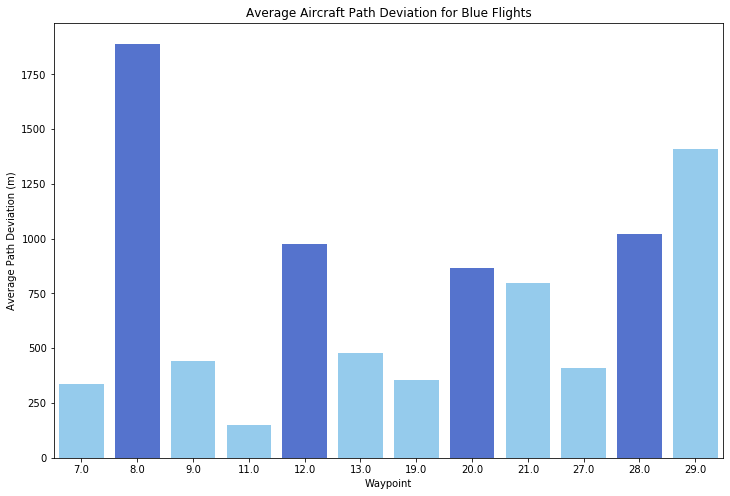

In [658]:
with engine.connect() as connection:
    path_deviation = pd.read_sql("""
        SELECT "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_5611620001340_P8666" WHERE "Event"<>-1
        UNION ALL SELECT "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6010571848831_P8099" WHERE "Event"<>-1
        UNION ALL SELECT "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6054129383014_P3233" WHERE "Event"<>-1
        UNION ALL SELECT "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6116054505008_P6109" WHERE "Event"<>-1
        UNION ALL SELECT "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6306616351170_P7442" WHERE "Event"<>-1
        UNION ALL SELECT "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6454302531282_P8543" WHERE "Event"<>-1
        UNION ALL SELECT "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6709586887529_P5510" WHERE "Event"<>-1
        UNION ALL SELECT "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_7167357727955_P5427" WHERE "Event"<>-1
        ORDER BY "NextWayPoint_code"
        """,connection)

path_deviation = path_deviation[path_deviation["NextWayPoint_code"].isin([7,8,9,11,12,13,19,20,21,27,28,29])]
grouped_path_deviation = path_deviation.groupby(["NextWayPoint_code"]).mean().reset_index()

fig, ax = plt.subplots(figsize=(12,8))
clrs = ['royalblue' if (x in [2,5,8,11]) else "lightskyblue" for x in grouped_no_responses["NextWayPoint_code"]]
sns.barplot(x="NextWayPoint_code",y="DistanceToPath_m",data=grouped_path_deviation,palette=clrs)
ax.set_title('Average Aircraft Path Deviation for Blue Flights')
ax.set_xlabel('Waypoint')
ax.set_ylabel('Average Path Deviation (m)')

This graph shows that average path deviation is noticably higher when pilots encounter the first threat event, but then stabilizes later in the flight path. This suggests that whereas n-back reaction time and accuracy did not reflect a learning or fatigue effect over the course of the flight, **there is a learning effect in path deviation** after the first threat. 

In general, **path deviation is higher at threat events compared to the segments immediately before and after**.

# Analyzing Gold
We now address these same four questions for the gold flight data by producing similar plots and comparing the results.
## Q1. Is there a learning/fatigue effect in the n-back task across the gold flight data?

[(0, 2000)]

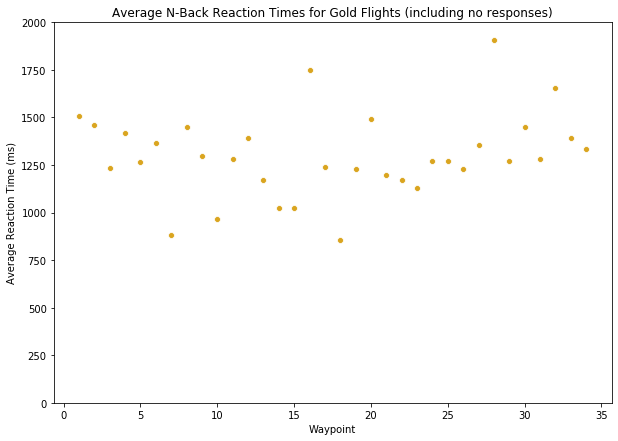

In [713]:
with engine.connect() as connection:
    reaction_times = pd.read_sql("""
        SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6152807954238_P3061"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6168263773276_P5454"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6201001215825_P3130"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6206460016536_P7234"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6239379978497_P7438"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6366148086779_P5521"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6704895162782_P8641"
        ORDER BY "NextWayPoint_code"
        """,connection)

reaction_times.loc[reaction_times["ReactionTime_msec"]==-1, ["ReactionTime_msec"]] = 3250
grouped_reaction_times = reaction_times.groupby(["NextWayPoint_code"]).mean().reset_index()

fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x="NextWayPoint_code",y="ReactionTime_msec",data=grouped_reaction_times,color="goldenrod")
ax.set_title('Average N-Back Reaction Times for Gold Flights (including no responses)')
ax.set_xlabel('Waypoint')
ax.set_ylabel('Average Reaction Time (ms)')
ax.set(ylim=(0, 2000))

As before, we see no clear trend in average reaction time over the course of the flights. We can therefore assume that there is no learning/fatigue effect in the n-back task across the gold flight data.

## Q2. What is the effect of threat events on n-back task reaction time in the gold flight data?

Text(0, 0.5, 'Proportion of Times Participants Did Not Respond')

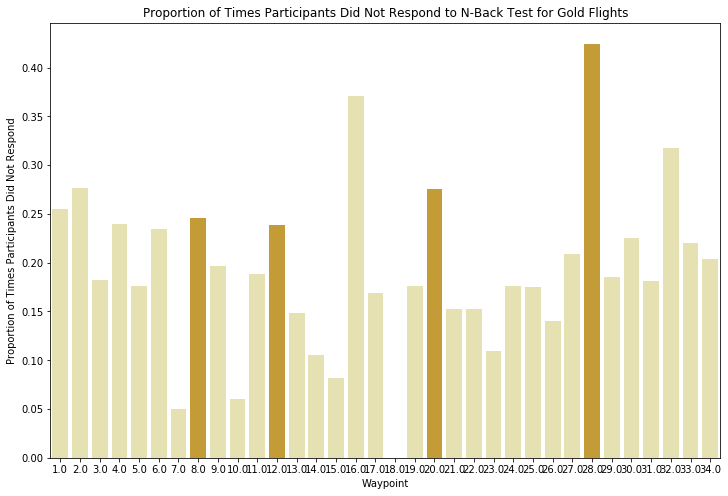

In [715]:
with engine.connect() as connection:
    no_responses = pd.read_sql("""
        SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") AS total, SUM(CASE WHEN "ReactionTime_msec"=-1 THEN 1 ELSE 0 END) AS missed FROM "Final_AFRLAgent_6152807954238_P3061" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") AS total, SUM(CASE WHEN "ReactionTime_msec"=-1 THEN 1 ELSE 0 END) AS missed FROM "Final_AFRLAgent_6168263773276_P5454" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") AS total, SUM(CASE WHEN "ReactionTime_msec"=-1 THEN 1 ELSE 0 END) AS missed FROM "Final_AFRLAgent_6201001215825_P3130" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") AS total, SUM(CASE WHEN "ReactionTime_msec"=-1 THEN 1 ELSE 0 END) AS missed FROM "Final_AFRLAgent_6206460016536_P7234" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") AS total, SUM(CASE WHEN "ReactionTime_msec"=-1 THEN 1 ELSE 0 END) AS missed FROM "Final_AFRLAgent_6239379978497_P7438" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") AS total, SUM(CASE WHEN "ReactionTime_msec"=-1 THEN 1 ELSE 0 END) AS missed FROM "Final_AFRLAgent_6366148086779_P5521" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ReactionTime_msec") AS total, SUM(CASE WHEN "ReactionTime_msec"=-1 THEN 1 ELSE 0 END) AS missed FROM "Final_AFRLAgent_6704895162782_P8641" GROUP BY "NextWayPoint_code"
        ORDER BY "NextWayPoint_code"
        """,connection)

grouped_no_responses = no_responses.groupby(["NextWayPoint_code"]).mean().reset_index()
grouped_no_responses["proportion"] = grouped_no_responses["missed"]/grouped_no_responses["total"]

fig, ax = plt.subplots(figsize=(12,8))
clrs = ['goldenrod' if (x in [8,12,20,28]) else "palegoldenrod" for x in grouped_no_responses["NextWayPoint_code"]]
sns.barplot(x="NextWayPoint_code",y="proportion",data=grouped_no_responses,palette=clrs)
ax.set_title('Proportion of Times Participants Did Not Respond to N-Back Test for Gold Flights')
ax.set_xlabel('Waypoint')
ax.set_ylabel('Proportion of Times Participants Did Not Respond')

Text(0, 0.5, 'N-Back Reaction Time (ms)')

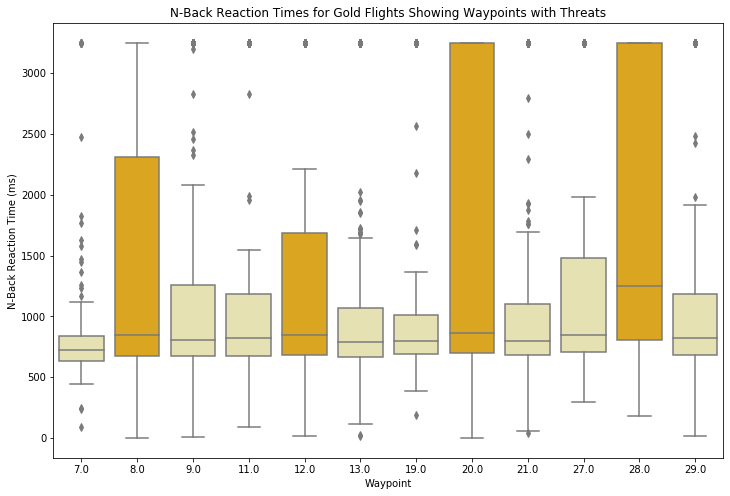

In [717]:
with engine.connect() as connection:
    reaction_times = pd.read_sql("""
        SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6152807954238_P3061"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6168263773276_P5454"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6201001215825_P3130"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6206460016536_P7234"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6239379978497_P7438"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6366148086779_P5521"
        UNION ALL SELECT "NextWayPoint_code", "ReactionTime_msec" FROM "Final_AFRLAgent_6704895162782_P8641"
        ORDER BY "NextWayPoint_code"
        """,connection)

reaction_times = reaction_times[reaction_times["NextWayPoint_code"].isin([7,8,9,11,12,13,19,20,21,27,28,29])]
reaction_times.loc[reaction_times["ReactionTime_msec"]==-1, ["ReactionTime_msec"]] = 3250

fig, ax = plt.subplots(figsize=(12,8))
ax = sns.boxplot(x="NextWayPoint_code", y="ReactionTime_msec", data=reaction_times,color="palegoldenrod")
boxes = [ax.artists[i] for i in [1,4,7,10]]
for box in boxes:
    box.set_facecolor("goldenrod")
ax.set_title('N-Back Reaction Times for Gold Flights Showing Waypoints with Threats')
ax.set_xlabel('Waypoint')
ax.set_ylabel('N-Back Reaction Time (ms)')

As before, waypoints with threat events correspond to higher proportions of times that participants did not respond to the n-back task, as well as slower reaction times in comparison to the segments immediately before and after.

## Q3. What is the effect of threat events on n-back task accuracy in the gold flight data?

Text(0, 0.5, 'Percent Correct (%)')

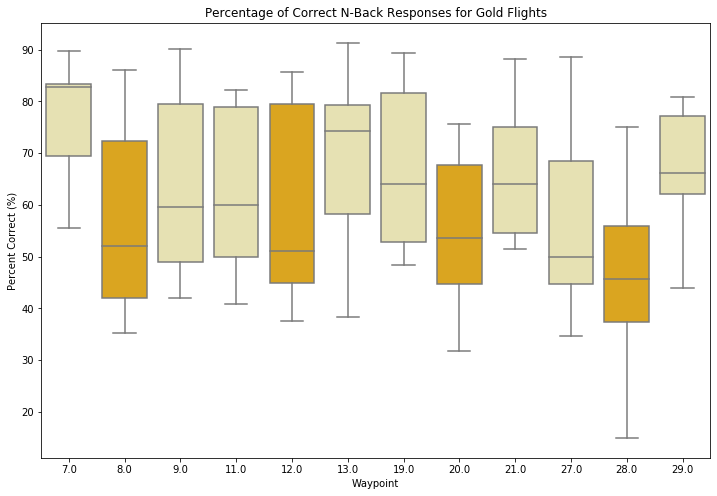

In [659]:
with engine.connect() as connection:
    answer_codes = pd.read_sql("""
        SELECT "NextWayPoint_code", COUNT("ExpectedAnswer_code") AS total, SUM(CASE WHEN "ExpectedAnswer_code"="AnswerGiven_code" THEN 1 ELSE 0 END) AS correct FROM "Final_AFRLAgent_6152807954238_P3061" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ExpectedAnswer_code") AS total, SUM(CASE WHEN "ExpectedAnswer_code"="AnswerGiven_code" THEN 1 ELSE 0 END) AS correct FROM "Final_AFRLAgent_6168263773276_P5454" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ExpectedAnswer_code") AS total, SUM(CASE WHEN "ExpectedAnswer_code"="AnswerGiven_code" THEN 1 ELSE 0 END) AS correct FROM "Final_AFRLAgent_6201001215825_P3130" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ExpectedAnswer_code") AS total, SUM(CASE WHEN "ExpectedAnswer_code"="AnswerGiven_code" THEN 1 ELSE 0 END) AS correct FROM "Final_AFRLAgent_6206460016536_P7234" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ExpectedAnswer_code") AS total, SUM(CASE WHEN "ExpectedAnswer_code"="AnswerGiven_code" THEN 1 ELSE 0 END) AS correct FROM "Final_AFRLAgent_6239379978497_P7438" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ExpectedAnswer_code") AS total, SUM(CASE WHEN "ExpectedAnswer_code"="AnswerGiven_code" THEN 1 ELSE 0 END) AS correct FROM "Final_AFRLAgent_6366148086779_P5521" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", COUNT("ExpectedAnswer_code") AS total, SUM(CASE WHEN "ExpectedAnswer_code"="AnswerGiven_code" THEN 1 ELSE 0 END) AS correct FROM "Final_AFRLAgent_6704895162782_P8641" GROUP BY "NextWayPoint_code"
        ORDER BY "NextWayPoint_code"
        """,connection)

answer_codes = answer_codes[answer_codes["NextWayPoint_code"].isin([7,8,9,11,12,13,19,20,21,27,28,29])]
answer_codes["percent_correct"] = (answer_codes["correct"]/answer_codes["total"])*100

fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x="NextWayPoint_code",y="percent_correct",data=answer_codes,color="palegoldenrod")
boxes = [ax.artists[i] for i in [1,4,7,10]]
for box in boxes:
    box.set_facecolor("goldenrod")
ax.set_title('Percentage of Correct N-Back Responses for Gold Flights')
ax.set_xlabel('Waypoint')
ax.set_ylabel('Percent Correct (%)')

As before, the percentage of correct n-back responses is consistently lower during threat events in comparison to the intervals immediately before and after.

## Q4. What is the effect of threat events on aircraft path deviation in the gold flight data?


Text(0, 0.5, 'Average Path Deviation (m)')

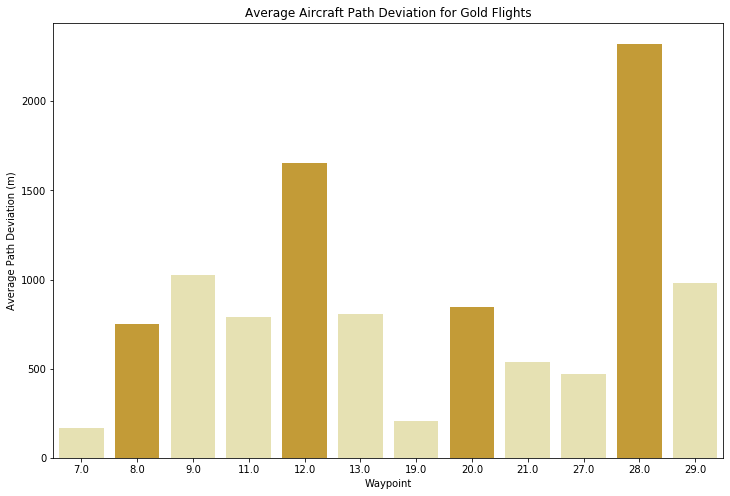

In [684]:
with engine.connect() as connection:
    path_deviation = pd.read_sql("""
        SELECT "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6152807954238_P3061" WHERE "Event"<>-1
        UNION ALL SELECT "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6168263773276_P5454" WHERE "Event"<>-1
        UNION ALL SELECT "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6201001215825_P3130" WHERE "Event"<>-1
        UNION ALL SELECT "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6206460016536_P7234" WHERE "Event"<>-1
        UNION ALL SELECT "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6239379978497_P7438" WHERE "Event"<>-1
        UNION ALL SELECT "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6366148086779_P5521" WHERE "Event"<>-1
        UNION ALL SELECT "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6704895162782_P8641" WHERE "Event"<>-1
        ORDER BY "NextWayPoint_code"
        """,connection)

path_deviation = path_deviation[path_deviation["NextWayPoint_code"].isin([7,8,9,11,12,13,19,20,21,27,28,29])]
grouped_path_deviation = path_deviation.groupby(["NextWayPoint_code"]).mean().reset_index()

fig, ax = plt.subplots(figsize=(12,8))
clrs = ['goldenrod' if (x in [2,5,8,11]) else "palegoldenrod" for x in grouped_no_responses["NextWayPoint_code"]]
sns.barplot(x="NextWayPoint_code",y="DistanceToPath_m",data=grouped_path_deviation,palette=clrs)
ax.set_title('Average Aircraft Path Deviation for Gold Flights')
ax.set_xlabel('Waypoint')
ax.set_ylabel('Average Path Deviation (m)')

As before, the average path deviation is noticably higher when pilots encounter the first threat event (recall that WP 28 corresponds to the first threat event for gold). In general, path deviation is still higher at threat events compared to the segments immediately before and after.

## Accounting for resets in the path deviation data
While our current data on aircraft path deviation appears to match our expectations, it is important to note that it does not account for resets in the simulation. Because pilots who are too far off course will be reset to a path deviation of zero, resets provide a potentially "unfair advantage" in comparison to participants who were not far enough off-course to meet the reset threshold. To eliminate this advantage, we must apply a path deviation penalty to resets.

In order to determine what this penalty should be, we plot the distribution of path deviation just before each waypoint for blue and gold.

[(0, 3500)]

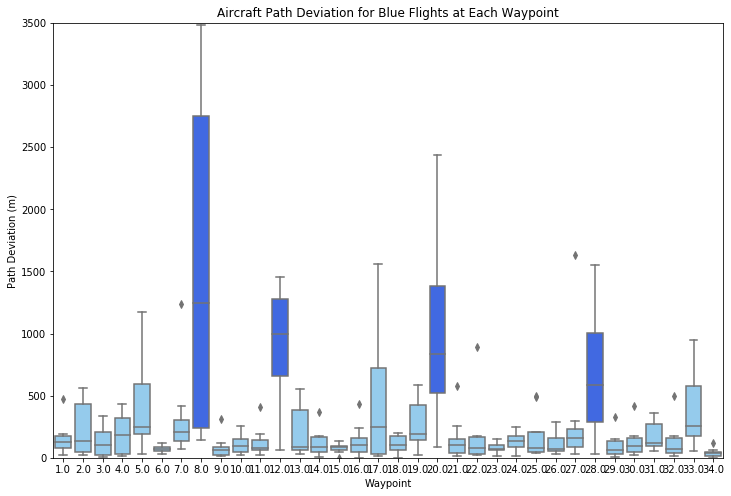

In [854]:
with engine.connect() as connection:
    path_deviation1 = pd.read_sql(""" SELECT "PreviousWayPoint_code", "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_5611620001340_P8666" WHERE "Event"=1 """,connection)
    path_deviation2 = pd.read_sql(""" SELECT "PreviousWayPoint_code", "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6010571848831_P8099" WHERE "Event"=1 """,connection)
    path_deviation3 = pd.read_sql(""" SELECT "PreviousWayPoint_code", "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6054129383014_P3233" WHERE "Event"=1 """,connection)
    path_deviation4 = pd.read_sql(""" SELECT "PreviousWayPoint_code", "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6116054505008_P6109" WHERE "Event"=1 """,connection)
    path_deviation5 = pd.read_sql(""" SELECT "PreviousWayPoint_code", "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6306616351170_P7442" WHERE "Event"=1 """,connection)
    path_deviation6 = pd.read_sql(""" SELECT "PreviousWayPoint_code", "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6454302531282_P8543" WHERE "Event"=1 """,connection)
    path_deviation7 = pd.read_sql(""" SELECT "PreviousWayPoint_code", "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6709586887529_P5510" WHERE "Event"=1 """,connection)
    path_deviation8 = pd.read_sql(""" SELECT "PreviousWayPoint_code", "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_7167357727955_P5427" WHERE "Event"=1 """,connection)

path_deviation1 = path_deviation1.dropna().groupby("NextWayPoint_code",as_index=False).apply(lambda x: x if len(x)==1 else x.iloc[[-15]]).reset_index(level=0, drop=True)
path_deviation2 = path_deviation2.dropna().groupby("NextWayPoint_code",as_index=False).apply(lambda x: x if len(x)==1 else x.iloc[[-15]]).reset_index(level=0, drop=True)
path_deviation3 = path_deviation3.dropna().groupby("NextWayPoint_code",as_index=False).apply(lambda x: x if len(x)==1 else x.iloc[[-15]]).reset_index(level=0, drop=True)
path_deviation4 = path_deviation4.dropna().groupby("NextWayPoint_code",as_index=False).apply(lambda x: x if len(x)==1 else x.iloc[[-15]]).reset_index(level=0, drop=True)
path_deviation5 = path_deviation5.dropna().groupby("NextWayPoint_code",as_index=False).apply(lambda x: x if len(x)==1 else x.iloc[[-15]]).reset_index(level=0, drop=True)
path_deviation6 = path_deviation6.dropna().groupby("NextWayPoint_code",as_index=False).apply(lambda x: x if len(x)==1 else x.iloc[[-15]]).reset_index(level=0, drop=True)
path_deviation7 = path_deviation7.dropna().groupby("NextWayPoint_code",as_index=False).apply(lambda x: x if len(x)==1 else x.iloc[[-15]]).reset_index(level=0, drop=True)
path_deviation8 = path_deviation8.dropna().groupby("NextWayPoint_code",as_index=False).apply(lambda x: x if len(x)==1 else x.iloc[[-15]]).reset_index(level=0, drop=True)
blue_path_deviation = pd.concat([path_deviation1, path_deviation2, path_deviation3, path_deviation4, path_deviation5, path_deviation6, path_deviation7, path_deviation8])

fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x="NextWayPoint_code",y="DistanceToPath_m",data=blue_path_deviation,color="lightskyblue")
boxes = [ax.artists[i] for i in [7,11,19,27]]
for box in boxes:
    box.set_facecolor("royalblue")
ax.set_title('Aircraft Path Deviation for Blue Flights at Each Waypoint')
ax.set_xlabel('Waypoint')
ax.set_ylabel('Path Deviation (m)')
ax.set(ylim=(0, 3500))

[(0, 3000)]

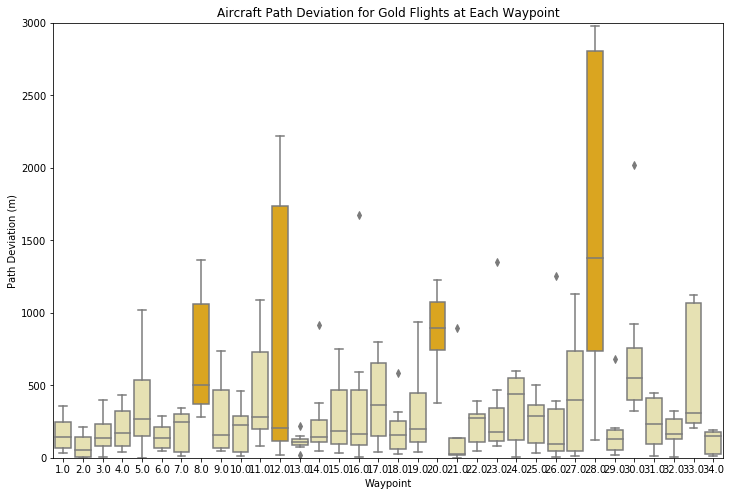

In [855]:
with engine.connect() as connection:
    path_deviation1 = pd.read_sql(""" SELECT "PreviousWayPoint_code", "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6152807954238_P3061" WHERE "Event"=1 """,connection)
    path_deviation2 = pd.read_sql(""" SELECT "PreviousWayPoint_code", "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6168263773276_P5454" WHERE "Event"=1 """,connection)
    path_deviation3 = pd.read_sql(""" SELECT "PreviousWayPoint_code", "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6201001215825_P3130" WHERE "Event"=1 """,connection)
    path_deviation4 = pd.read_sql(""" SELECT "PreviousWayPoint_code", "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6206460016536_P7234" WHERE "Event"=1 """,connection)
    path_deviation5 = pd.read_sql(""" SELECT "PreviousWayPoint_code", "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6239379978497_P7438" WHERE "Event"=1 """,connection)
    path_deviation6 = pd.read_sql(""" SELECT "PreviousWayPoint_code", "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6366148086779_P5521" WHERE "Event"=1 """,connection)
    path_deviation7 = pd.read_sql(""" SELECT "PreviousWayPoint_code", "NextWayPoint_code", "DistanceToPath_m" FROM "Final_AFRLAgent_6704895162782_P8641" WHERE "Event"=1 """,connection)

path_deviation1 = path_deviation1.dropna().groupby("NextWayPoint_code",as_index=False).apply(lambda x: x if len(x)==1 else x.iloc[[-15]]).reset_index(level=0, drop=True)
path_deviation2 = path_deviation2.dropna().groupby("NextWayPoint_code",as_index=False).apply(lambda x: x if len(x)==1 else x.iloc[[-15]]).reset_index(level=0, drop=True)
path_deviation3 = path_deviation3.dropna().groupby("NextWayPoint_code",as_index=False).apply(lambda x: x if len(x)==1 else x.iloc[[-15]]).reset_index(level=0, drop=True)
path_deviation4 = path_deviation4.dropna().groupby("NextWayPoint_code",as_index=False).apply(lambda x: x if len(x)==1 else x.iloc[[-15]]).reset_index(level=0, drop=True)
path_deviation5 = path_deviation5.dropna().groupby("NextWayPoint_code",as_index=False).apply(lambda x: x if len(x)==1 else x.iloc[[-15]]).reset_index(level=0, drop=True)
path_deviation6 = path_deviation6.dropna().groupby("NextWayPoint_code",as_index=False).apply(lambda x: x if len(x)==1 else x.iloc[[-15]]).reset_index(level=0, drop=True)
path_deviation7 = path_deviation7.dropna().groupby("NextWayPoint_code",as_index=False).apply(lambda x: x if len(x)==1 else x.iloc[[-15]]).reset_index(level=0, drop=True)
gold_path_deviation = pd.concat([path_deviation1, path_deviation2, path_deviation3, path_deviation4, path_deviation5, path_deviation6, path_deviation7])

fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x="NextWayPoint_code",y="DistanceToPath_m",data=gold_path_deviation,color="palegoldenrod")
boxes = [ax.artists[i] for i in [7,11,19,27]]
for box in boxes:
    box.set_facecolor("goldenrod")
ax.set_title('Aircraft Path Deviation for Gold Flights at Each Waypoint')
ax.set_xlabel('Waypoint')
ax.set_ylabel('Path Deviation (m)')
ax.set(ylim=(0, 3000))

In both cases, we observe a clear separation between the path deviation at threat events and the path deviation at non-threat events. We therefore split the data into these two groups and calculate summary statistics across both the blue and gold flight data.

In [878]:
combined_path_deviation = pd.concat([blue_path_deviation,gold_path_deviation])
threat_path_deviation = combined_path_deviation[combined_path_deviation["NextWayPoint_code"].isin([8,12,20,28])]["DistanceToPath_m"]
normal_path_deviation = combined_path_deviation[~combined_path_deviation["NextWayPoint_code"].isin([8,12,20,28])]["DistanceToPath_m"]

As shown below, the path deviation at threat events has **avg = 1156m with std = 1327m**

In [879]:
threat_path_deviation[(np.abs(stats.zscore(threat_path_deviation)) < 3)].describe()

count      58.000000
mean     1156.368964
std      1327.113515
min        21.059639
25%       329.736053
50%       838.939118
75%      1339.833814
max      8006.993270
Name: DistanceToPath_m, dtype: float64

Similarly, the path deviation at non-threat events has **avg = 213m with std = 243m**

In [881]:
normal_path_deviation[(np.abs(stats.zscore(normal_path_deviation)) < 3)].describe()

count     445.000000
mean      212.591443
std       242.564483
min         0.348430
25%        50.661460
50%       132.962074
75%       280.892568
max      1352.480570
Name: DistanceToPath_m, dtype: float64

## Applying penalties to resets in the path deviation data
To apply these penalties, we find the average path deviation in each leg of each segment of each flight path and check whether a reset occurred and whether that reset happened at a threat event or a non-threat event. After applying the appropriate penalties, we finally group all of the data by waypoint.

In [909]:
with engine.connect() as connection:
    path_deviation = pd.read_sql("""
        SELECT "NextWayPoint_code", AVG("DistanceToPath_m"), SUM(CASE WHEN "Event"=-1 THEN 1 ELSE 0 END) FROM "Final_AFRLAgent_6152807954238_P3061" GROUP BY "NextWayPoint_code" 
        UNION ALL SELECT "NextWayPoint_code", AVG("DistanceToPath_m"), SUM(CASE WHEN "Event"=-1 THEN 1 ELSE 0 END) FROM "Final_AFRLAgent_6168263773276_P5454" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", AVG("DistanceToPath_m"), SUM(CASE WHEN "Event"=-1 THEN 1 ELSE 0 END) FROM "Final_AFRLAgent_6201001215825_P3130" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", AVG("DistanceToPath_m"), SUM(CASE WHEN "Event"=-1 THEN 1 ELSE 0 END) FROM "Final_AFRLAgent_6206460016536_P7234" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", AVG("DistanceToPath_m"), SUM(CASE WHEN "Event"=-1 THEN 1 ELSE 0 END) FROM "Final_AFRLAgent_6239379978497_P7438" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", AVG("DistanceToPath_m"), SUM(CASE WHEN "Event"=-1 THEN 1 ELSE 0 END) FROM "Final_AFRLAgent_6366148086779_P5521" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", AVG("DistanceToPath_m"), SUM(CASE WHEN "Event"=-1 THEN 1 ELSE 0 END) FROM "Final_AFRLAgent_6704895162782_P8641" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", AVG("DistanceToPath_m"), SUM(CASE WHEN "Event"=-1 THEN 1 ELSE 0 END) FROM "Final_AFRLAgent_5611620001340_P8666" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", AVG("DistanceToPath_m"), SUM(CASE WHEN "Event"=-1 THEN 1 ELSE 0 END) FROM "Final_AFRLAgent_6010571848831_P8099" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", AVG("DistanceToPath_m"), SUM(CASE WHEN "Event"=-1 THEN 1 ELSE 0 END) FROM "Final_AFRLAgent_6054129383014_P3233" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", AVG("DistanceToPath_m"), SUM(CASE WHEN "Event"=-1 THEN 1 ELSE 0 END) FROM "Final_AFRLAgent_6116054505008_P6109" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", AVG("DistanceToPath_m"), SUM(CASE WHEN "Event"=-1 THEN 1 ELSE 0 END) FROM "Final_AFRLAgent_6306616351170_P7442" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", AVG("DistanceToPath_m"), SUM(CASE WHEN "Event"=-1 THEN 1 ELSE 0 END) FROM "Final_AFRLAgent_6454302531282_P8543" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", AVG("DistanceToPath_m"), SUM(CASE WHEN "Event"=-1 THEN 1 ELSE 0 END) FROM "Final_AFRLAgent_6709586887529_P5510" GROUP BY "NextWayPoint_code"
        UNION ALL SELECT "NextWayPoint_code", AVG("DistanceToPath_m"), SUM(CASE WHEN "Event"=-1 THEN 1 ELSE 0 END) FROM "Final_AFRLAgent_7167357727955_P5427" GROUP BY "NextWayPoint_code"
        ORDER BY "NextWayPoint_code"
        """,connection)

We use the following penalty function to check for resets and apply the appropriate penalty to the average path deviation column (depending on whether the reset occurs at a threat or a non-threat event).

In [904]:
def penalty(event):
    if event['sum'] > 0:
        if event['NextWayPoint_code'] in [8,12,20,28]:
            return event+1156
        else:
            return event+213
    else:
        return event

After applying the penalties to the combined blue and gold data, we see a regular pattern in path deviation across the entire flight path and very clear separation between threat and non-threat events.

[(0, 8000)]

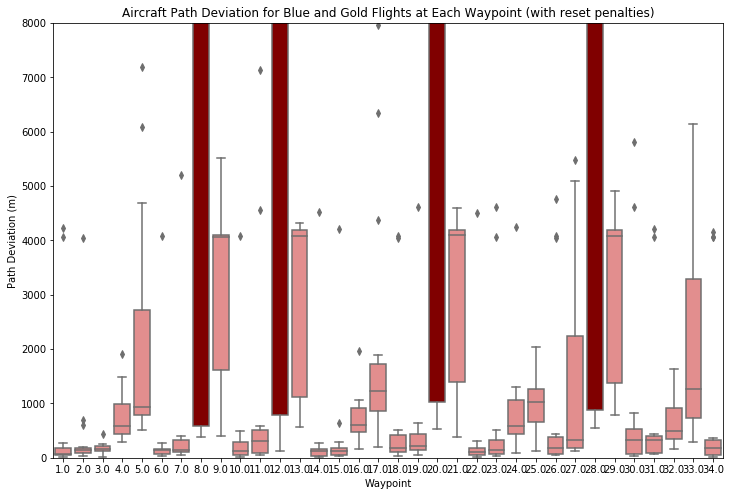

In [928]:
path_deviation['avg'] = path_deviation.apply(penalty,axis=1)['avg']

fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(x="NextWayPoint_code",y="avg",data=path_deviation,color="lightcoral")
boxes = [ax.artists[i] for i in [7,11,19,27]]
for box in boxes:
    box.set_facecolor("maroon")
ax.set_title('Aircraft Path Deviation for Blue and Gold Flights at Each Waypoint (with reset penalties)')
ax.set_xlabel('Waypoint')
ax.set_ylabel('Path Deviation (m)')
ax.set(ylim=(0, 8000))